In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [435]:
ec= pd.read_csv('../dataAnalysis/monthly_08_eclipse.csv')
#ec['datetime'] = pd.to_datetime(ec['Unnamed: 0'])

# algorithmically look at each point and if it near the roadways
ids = ec.DeviceId.unique()

lo,la,ec_no2,ec_pm25,cmaq_no2,cmaq_pm25 = [],[],[],[],[],[]
for i in range(len(ids)):
    tmp = ec[ec.DeviceId == ids[i]]
    lo.append(tmp.Longitude.unique()[0]);la.append(tmp.Latitude.unique()[0])
    cmaq_no2.append(np.mean(tmp.NO2));
    cmaq_pm25.append(np.mean(tmp.PM25_TOT));
    ec_no2.append(np.mean(tmp.CalibratedNO2));
    ec_pm25.append(np.mean(tmp.CalibratedPM25));

ids = [int(ids[i]) for i in range(len(ids))]

geometry = [Point(lo[i],la[i]) for i in range(len(lo))]
eclipse = gpd.GeoDataFrame(pd.DataFrame([ids,lo,la,ec_no2,ec_pm25,cmaq_no2,cmaq_pm25]).T,geometry = geometry,crs ={'init': 'epsg:4326'})
eclipse.columns = ['ids','lon','lat','ec_no2','ec_pm25','cmaq_no2','cmaq_pm25','geometry']
eclipse


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,ids,lon,lat,ec_no2,ec_pm25,cmaq_no2,cmaq_pm25,geometry
0,2002.0,-87.625857,41.794921,9.685696,12.794769,13.747754,11.619959,POINT (-87.62586 41.79492)
1,2003.0,-87.625500,41.795500,8.092448,12.115704,13.747754,11.619959,POINT (-87.62550 41.79550)
2,2004.0,-87.695204,41.845100,10.212403,13.687532,19.068060,12.643562,POINT (-87.69520 41.84510)
3,2005.0,-87.695200,41.852400,9.833608,13.833757,18.049189,12.489958,POINT (-87.69520 41.85240)
4,2006.0,-87.695400,41.852300,10.853654,13.970006,18.049189,12.489958,POINT (-87.69540 41.85230)
...,...,...,...,...,...,...,...,...
82,2150.0,-87.764700,41.880300,9.167888,13.031814,13.532202,12.003487,POINT (-87.76470 41.88030)
83,2174.0,-87.729633,41.844104,14.513113,15.275407,17.490239,12.680948,POINT (-87.72963 41.84410)
84,2176.0,-87.539967,41.688054,5.317141,8.793844,10.817750,11.951467,POINT (-87.53997 41.68805)
85,2184.0,-87.672189,41.881471,15.486077,13.079416,18.218984,12.936218,POINT (-87.67219 41.88147)


In [436]:
streets = gpd.read_file('../shapefiles/geo_export_d268c11a-e3fe-42de-a88f-ad64688102f5.shp')
# make meters EPSG so we can check buffers# make meters EPSG so we can check buffers
streets = streets.to_crs("EPSG:3857")
eclipse = eclipse.to_crs(streets.crs)

class1 = streets[streets['class'] == '1'].reset_index(drop=True)
class2 = streets[streets['class'] == '2'].reset_index(drop=True)

In [437]:
# calculate distance of eclipse to hwy
single_track_line = class1.unary_union

eclipse['dist'] = eclipse.distance(single_track_line)

In [438]:
a = []
for i in range(len(class1)):
    a.append(list(eclipse.distance(class1.geometry[i])))

a=pd.DataFrame(a)
mina = a.idxmin()

In [439]:
eclipse['height'] = [class1['t_zlev'][mina[i]] for i in range(len(mina))]

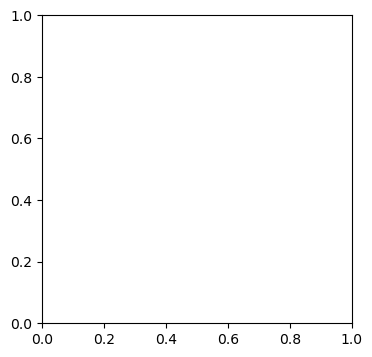

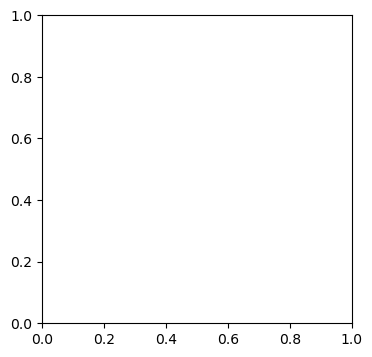

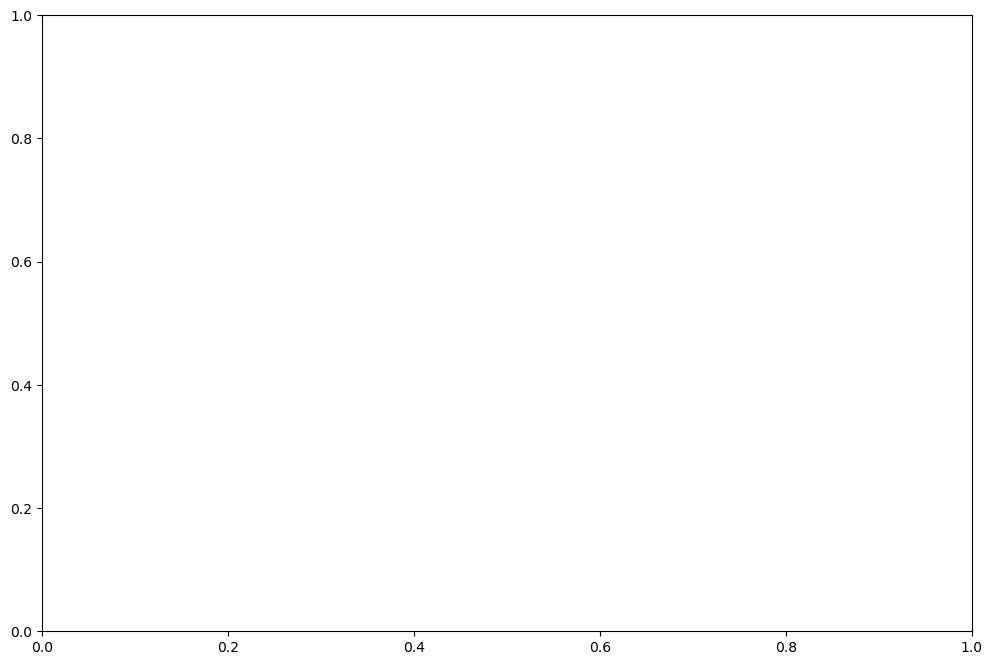

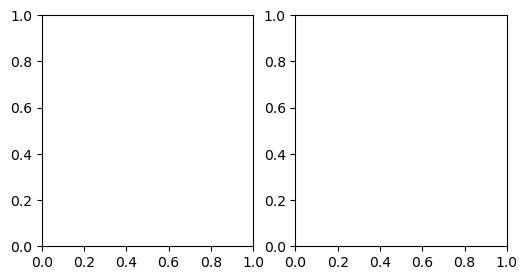

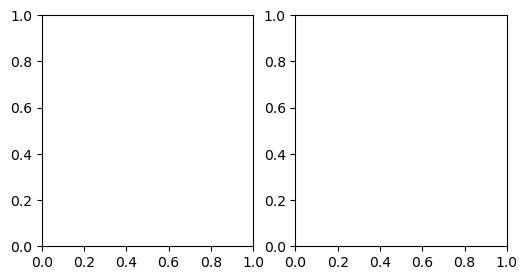

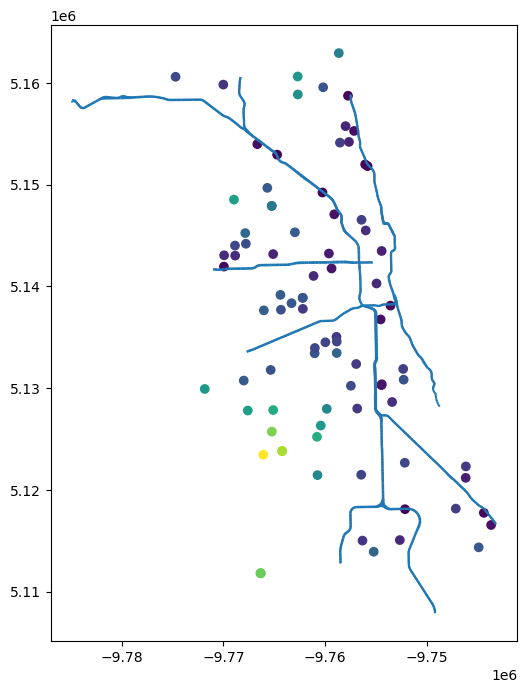

In [440]:
fig,ax=plt.subplots(figsize=(12,8))

chi_shp = gpd.read_file('../shapefiles/geo_export_77af1a6a-f8ec-47f4-977c-40956cd94f97.shp')

eclipse.plot('dist',ax=ax)
class1.plot(ax=ax)
plt.show()


# how to add in zlev info?

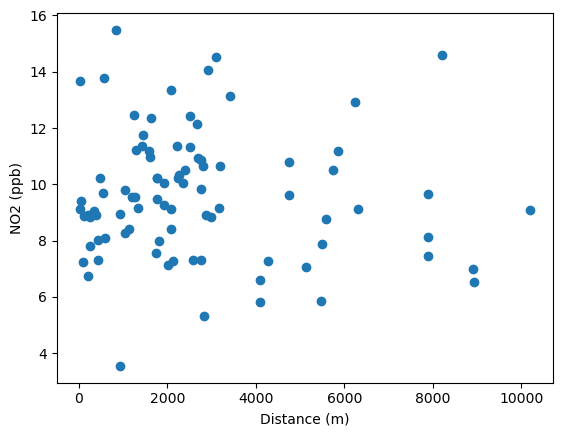

In [441]:
plt.scatter(eclipse.dist,eclipse.ec_no2)
plt.xlabel('Distance (m)')
plt.ylabel('NO2 (ppb)')
plt.show()

In [442]:
eclipse[eclipse.ids == 2136]

,ids,lon,lat,ec_no2,ec_pm25,cmaq_no2,cmaq_pm25,geometry,dist,height
77,2136.0,-87.6779,41.921581,9.415527,12.099551,17.848062,12.603656,POINT (-9760259.182 5149239.887),50.586668,1.0


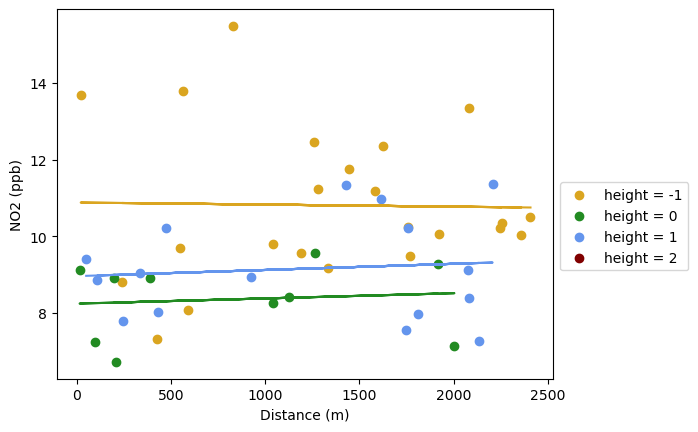

In [450]:
c = ['forestgreen','cornflowerblue','maroon','goldenrod']

for i in range(-1,3):
    x = eclipse[(eclipse.height == i) & (eclipse.dist < 2500) & (eclipse.ec_no2 > 5)]
    plt.scatter(x.dist,x.ec_no2,c = c[i],label = 'height = '+str(i))
    #if (np.sum(x.ids == 2013)> 0):
        #f = eclipse[eclipse.ids == 2013]
        #plt.scatter(f.dist,f.ec_no2,label='Village')
    if len(x.dist) > 0:
        m, b = np.polyfit(x.dist, x.ec_no2, 1)
        xi = x.dist
        plt.plot(xi, m*xi+b, c=c[i])

plt.xlabel('Distance (m)')
plt.ylabel('NO2 (ppb)')
plt.legend(bbox_to_anchor =(1, 0.55))

plt.show()

In [451]:
eclipse

,ids,lon,lat,ec_no2,ec_pm25,cmaq_no2,cmaq_pm25,geometry,dist,height
0,2002.0,-87.625857,41.794921,9.685696,12.794769,13.747754,11.619959,POINT (-9754465.782 5130308.935),547.996154,-1.0
1,2003.0,-87.625500,41.795500,8.092448,12.115704,13.747754,11.619959,POINT (-9754426.041 5130395.389),589.094918,-1.0
2,2004.0,-87.695204,41.845100,10.212403,13.687532,19.068060,12.643562,POINT (-9762185.454 5137804.343),1755.560572,1.0
3,2005.0,-87.695200,41.852400,9.833608,13.833757,18.049189,12.489958,POINT (-9762185.009 5138895.258),2758.785966,1.0
4,2006.0,-87.695400,41.852300,10.853654,13.970006,18.049189,12.489958,POINT (-9762207.273 5138880.313),2753.904458,1.0
...,...,...,...,...,...,...,...,...,...,...
82,2150.0,-87.764700,41.880300,9.167888,13.031814,13.532202,12.003487,POINT (-9769921.714 5143065.795),1333.465459,-1.0
83,2174.0,-87.729633,41.844104,14.513113,15.275407,17.490239,12.680948,POINT (-9766018.073 5137655.510),3108.920954,1.0
84,2176.0,-87.539967,41.688054,5.317141,8.793844,10.817750,11.951467,POINT (-9744904.550 5114365.380),2823.035440,1.0
85,2184.0,-87.672189,41.881471,15.486077,13.079416,18.218984,12.936218,POINT (-9759623.436 5143240.878),831.154685,-1.0


In [445]:
(eclipse[(eclipse.height == i) & (eclipse.dist < 2000) & (eclipse.ec_no2 > 5)]['ec_no2'] - eclipse.ec_no2.min())/(eclipse.ec_no2.max() - eclipse.ec_no2.min())

Series([], Name: ec_no2, dtype: float64)

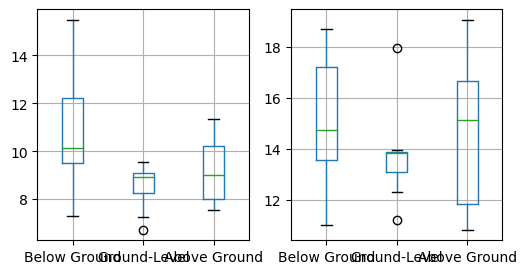

In [452]:
c = ['forestgreen','cornflowerblue','maroon','goldenrod']
fig,ax = plt.subplots(1,2,figsize = (6,3))
tmp = []
tmp2 = []

for i in range(-1,2):
    t = eclipse[(eclipse.height == i) & (eclipse.dist < 2000) & (eclipse.ec_no2 > 5)]['ec_no2']
    tmp.append(t)
    t = eclipse[(eclipse.height == i) & (eclipse.dist < 2000) & (eclipse.ec_no2 > 5)]['cmaq_no2']
    tmp2.append(t)
    #tmp2.append((eclipse[(eclipse.height == i) & (eclipse.dist < 2000) & (eclipse.ec_no2 > 5)]['cmaq_no2'] - eclipse.cmaq_no2.min())/(eclipse.cmaq_no2.max() - eclipse.cmaq_no2.min()))


x = pd.DataFrame(tmp).T
x.columns = ['Below Ground','Ground-Level','Above Ground']


x2 = pd.DataFrame(tmp2).T
x2.columns = ['Below Ground','Ground-Level','Above Ground']

x.boxplot(ax=ax[0])
x2.boxplot(ax=ax[1])

plt.show()

In [454]:
(np.nanmean(x['Below Ground']) - np.nanmean(x['Above Ground']))/np.nanmean(x['Below Ground'])

0.1473966936564642

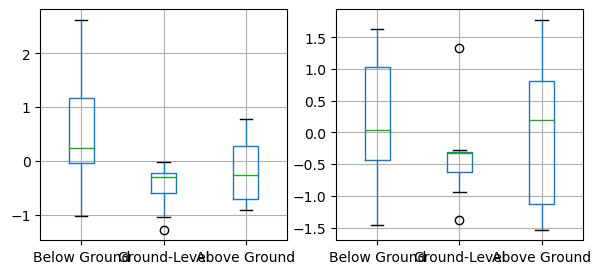

In [447]:
c = ['forestgreen','cornflowerblue','maroon','goldenrod']
fig,ax = plt.subplots(1,2,figsize = (7,3))
tmp = []
tmp2 = []

for i in range(-1,2):
    t = (eclipse[(eclipse.height == i) & (eclipse.dist < 2000) & (eclipse.ec_no2 > 5)]['ec_no2'] - eclipse.ec_no2.min())/(eclipse.ec_no2.max() - eclipse.ec_no2.min())
    t =(eclipse[(eclipse.height == i) & (eclipse.dist < 2000) & (eclipse.ec_no2 > 5)]['ec_no2'] - eclipse.ec_no2.mean())/(np.std(eclipse.ec_no2))
    tmp.append(t)
    t = (eclipse[(eclipse.height == i) & (eclipse.dist < 2000) & (eclipse.ec_no2 > 5)]['cmaq_no2'] - eclipse.cmaq_no2.min())/(eclipse.cmaq_no2.max() - eclipse.cmaq_no2.min())
    t = (eclipse[(eclipse.height == i) & (eclipse.dist < 2000) & (eclipse.ec_no2 > 5)]['cmaq_no2'] - eclipse.cmaq_no2.mean())/(np.std(eclipse.cmaq_no2))
    tmp2.append(t)
    #tmp2.append((eclipse[(eclipse.height == i) & (eclipse.dist < 2000) & (eclipse.ec_no2 > 5)]['cmaq_no2'] - eclipse.cmaq_no2.min())/(eclipse.cmaq_no2.max() - eclipse.cmaq_no2.min()))


x = pd.DataFrame(tmp).T
x.columns = ['Below Ground','Ground-Level','Above Ground']


x2 = pd.DataFrame(tmp2).T
x2.columns = ['Below Ground','Ground-Level','Above Ground']

x.boxplot(ax=ax[0])
x2.boxplot(ax=ax[1])

plt.show()


In [448]:
x2.describe()

,Below Ground,Ground-Level,Above Ground
count,18.000000,9.000000,12.000000
mean,0.236150,-0.384080,-0.009724
std,0.938613,0.738591,1.122699
min,-1.462253,-1.378021,-1.535893
25%,-0.429764,-0.628671,-1.131797
50%,0.031370,-0.323028,0.196669
75%,1.038753,-0.307306,0.812240
max,1.638622,1.328859,1.778829


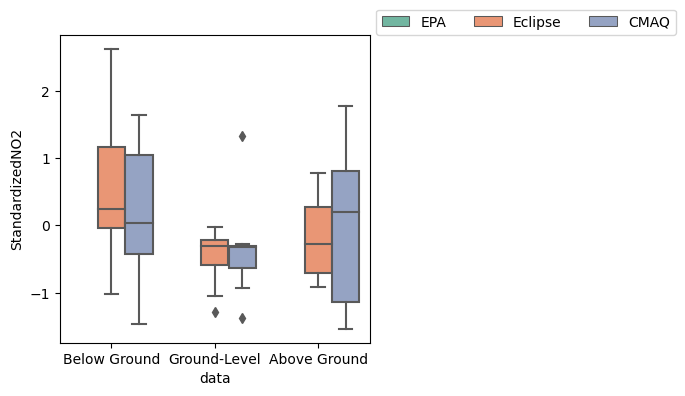

Comparing CMAQ vs. Exlipse
0.3616988158463901
0.7039327590329014
0.6429257806872695
Comparing Eclipse: Above-Below
0.028572513429796765
Comparing CMAQ: Above-Below
0.5209593160009498
diff between belowground-above eclipse:
0.7091235144664567


In [449]:
import seaborn as sns
palette =sns.color_palette("Set2",3)

x['DataSource'] = 'Eclipse'
x2['DataSource'] = 'CMAQ'
df = pd.concat([x,x2])
df_m = pd.melt(df, id_vars=['DataSource'],var_name='data', value_name='StandardizedNO2')
col = df_m.columns
# dummy holder for EPA
df_m = pd.DataFrame(np.insert(df_m.values, 0, values= ['EPA','Below Ground',np.nan], axis=0))
df_m.columns = col

fig,ax = plt.subplots(figsize=(4,4))
#import seaborn as sns
sns.boxplot(x = 'data', y = 'StandardizedNO2', data = df_m, hue = 'DataSource', palette=palette,ax=ax)
plt.legend(bbox_to_anchor=(1.02, 1), loc='lower left', borderaxespad=0, ncol = 3)

plt.show()
x2.describe()

import scipy.stats as stats

print('Comparing CMAQ vs. Exlipse')
print(stats.ttest_ind(a=x['Below Ground'][~np.isnan(x['Below Ground'])], b=x2['Below Ground'][~np.isnan(x2['Below Ground'])], equal_var=False)[1])
print(stats.ttest_ind(a=x['Ground-Level'][~np.isnan(x['Ground-Level'])], b=x2['Ground-Level'][~np.isnan(x2['Ground-Level'])], equal_var=False)[1])
print(stats.ttest_ind(a=x['Above Ground'][~np.isnan(x['Above Ground'])], b=x2['Above Ground'][~np.isnan(x2['Above Ground'])], equal_var=False)[1])

print('Comparing Eclipse: Above-Below')
print(stats.ttest_ind(a=x['Above Ground'][~np.isnan(x['Above Ground'])], b=x['Below Ground'][~np.isnan(x['Below Ground'])], equal_var=True)[1])

print('Comparing CMAQ: Above-Below')
print(stats.ttest_ind(a=x2['Above Ground'][~np.isnan(x2['Above Ground'])], b=x2['Below Ground'][~np.isnan(x2['Below Ground'])], equal_var=True)[1])

print("diff between belowground-above eclipse:")
print(np.mean(x['Below Ground']) - np.mean(x['Above Ground']))

In [ ]:
ec = pd.read_csv('')

In [58]:
ec.columns

Index(['Unnamed: 0', 'DeviceId', 'Unnamed: 0.1', 'Latitude', 'Longitude', 'CO',
       'SO2', 'NO2', 'O3', 'TempC', 'Humidity', 'Pressure', 'PM25', 'PM10',
       'PM1', 'VBat', 'Signal', 'MSRDeviceNbr', 'FWVersion', 'RawCO', 'RawSO2',
       'RawNO2', 'RawO3', 'AQI', 'ExtTempC', 'PMConc05', 'PMConc1', 'PMConc25',
       'PMConc10', 'PMTypSize', 'OutlierInd', 'CalibratedPM25',
       'CalibratedNO2', 'latlon', 'BENZENE', 'FORM', 'NO', 'NOX', 'PBLH',
       'PM25_EC', 'PM25_HP', 'PM25_NO3', 'PM25_OC', 'PM25_SOIL', 'PM25_TOT',
       'RH', 'SFC_TMP', 'U10', 'V10', 'VOC', 'precip', 'xx', 'datetime'],
      dtype='object')

In [60]:
ec[ec.DeviceId == 2062].CalibratedNO2

34968    1.542500
34969    1.353636
34970    1.425000
34971    0.989167
34972    0.980909
           ...   
35707    1.887273
35708    1.695000
35709    1.696667
35710    1.778182
35711    1.560000
Name: CalibratedNO2, Length: 744, dtype: float64

In [333]:
eclipse = pd.read_csv('data_cleaned_and_dropped.csv',index_col = 0)
eclipse = eclipse[eclipse.DeviceId == 2136].reset_index(drop=True)
eclipse['dt'] = pd.to_datetime(eclipse['Unnamed: 0.1'])
eclipse

,Unnamed: 0.1,DeviceId,Unnamed: 0.1.1,Latitude,Longitude,CO,SO2,NO2,O3,TempC,...,PM25_SOIL,PM25_TOT,RH,SFC_TMP,U10,V10,VOC,precip,xx,dt
0,2021-08-01 00:00:00,2136,735165.5,41.921581,-87.6779,283.250610,0.629431,11.367180,55.374599,28.006344,...,2.698906,11.354993,39.519768,27.831482,0.188784,-1.069935,60.758419,0.187898,"(123, 139)",2021-08-01 00:00:00
1,2021-08-01 01:00:00,2136,735154.0,41.921581,-87.6779,500.182739,1.415413,31.782146,33.148540,26.751126,...,5.342179,23.034973,46.052631,26.352112,-0.468434,-0.240831,135.114807,0.187898,"(123, 139)",2021-08-01 01:00:00
2,2021-08-01 02:00:00,2136,735142.5,41.921581,-87.6779,408.035736,1.628307,29.383326,18.290941,25.812925,...,5.482185,18.707493,52.642487,24.821472,0.908163,0.618858,138.883698,0.187898,"(123, 139)",2021-08-01 02:00:00
3,2021-08-01 03:00:00,2136,735130.5,41.921581,-87.6779,304.643616,0.896835,19.863340,21.842386,25.170720,...,5.728775,18.933851,59.602417,23.693634,1.599625,0.914898,102.512405,0.187898,"(123, 139)",2021-08-01 03:00:00
4,2021-08-01 04:00:00,2136,735119.0,41.921581,-87.6779,236.355469,0.685735,14.758755,22.522469,24.634316,...,4.857190,15.592884,65.297874,22.739227,1.841673,1.120171,79.571693,0.187898,"(123, 139)",2021-08-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,2021-08-31 19:00:00,2136,726782.0,41.921581,-87.6779,160.913361,0.931143,3.368696,47.829231,29.562697,...,0.671031,5.396742,52.139576,26.427887,-3.400907,-1.481641,21.728268,125.519073,"(123, 139)",2021-08-31 19:00:00
740,2021-08-31 20:00:00,2136,726770.5,41.921581,-87.6779,167.762558,0.504359,3.394891,44.877285,28.505688,...,0.661490,4.496163,50.587791,26.430023,-3.503312,-1.739476,22.895237,125.519073,"(123, 139)",2021-08-31 20:00:00
741,2021-08-31 21:00:00,2136,726759.5,41.921581,-87.6779,174.899979,0.358186,3.578000,42.222771,28.464699,...,0.677095,3.967630,51.528198,26.224274,-3.463934,-2.316332,24.335913,125.519073,"(123, 139)",2021-08-31 21:00:00
742,2021-08-31 22:00:00,2136,726748.5,41.921581,-87.6779,174.899979,0.358186,3.578000,42.222771,27.528585,...,0.677095,3.967630,51.528198,26.224274,-3.463934,-2.316332,24.335913,125.519073,"(123, 139)",2021-08-31 22:00:00


In [394]:
d = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/cmaq/code/Users/t-stacym/'
ts = pd.read_csv(d+'NO2'+'_082021_epa.csv',index_col=0)

ts=ts[ts['xx'] == 122].reset_index()

In [395]:
ts['ReadingDateTimeUTC'] = pd.to_datetime(ts['ReadingDateTimeUTC'])

In [396]:
ts.columns

Index(['index', 'site_number', 'ReadingDateTimeUTC', 'poc', 'latitude',
       'longitude', 'sample_measurement', 'detection_limit', 'CMAQ_NO2', 'xx',
       'yy', 'hour', 'sitenum'],
      dtype='object')

In [397]:
cmaq = ts[['ReadingDateTimeUTC','CMAQ_NO2']]
cmaq.columns = ['dt','no2']

epa = ts[['ReadingDateTimeUTC','sample_measurement']]
epa.columns = ['dt','no2']

ec = eclipse[['dt','CalibratedNO2']]
ec.columns = ['dt','no2']

epa['DataSource'] = 'EPA'
cmaq['DataSource'] = 'CMAQ'
ec['DataSource'] = 'Eclipse'

data = pd.concat([epa, ec, cmaq], axis=0)
#df = pd.concat([x,x2])
#df_m = pd.melt(df, id_vars=['DataSource'],var_name='data', value_name='StandardizedNO2')
data = pd.melt(data, id_vars=['DataSource','dt'],var_name='data', value_name='no2')
data = data[data.DataSource!='1']
data = data[data.DataSource!=1]

<ipython-input-397-0abfef5a0a40>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epa['DataSource'] = 'EPA'
<ipython-input-397-0abfef5a0a40>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmaq['DataSource'] = 'CMAQ'
<ipython-input-397-0abfef5a0a40>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

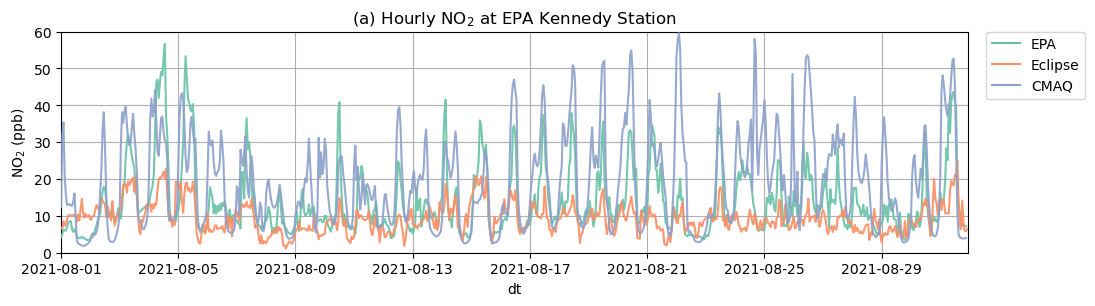

In [399]:
palette =sns.color_palette("Set2",3)

fig,ax= plt.subplots(figsize=(11,3))


sns.lineplot(x='dt',y='no2',data=data,hue="DataSource",palette=palette,ax=ax,
                alpha=0.9,zorder=1000,linewidth = 1.5)#, edgecolor='k',s= 20)

ax.set_ylim([0,60])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
ax.set_ylabel(r'NO$_2$ (ppb)')
ax.set_xlim([data.dt.min(),data.dt.max()])
ax.grid()
ax.set_title('(a) Hourly NO$_2$ at EPA Kennedy Station')
plt.show()



In [400]:
data.groupby('DataSource').mean()


,no2
DataSource,
CMAQ,19.164789
EPA,13.889959
Eclipse,9.415527


In [401]:
data[(data.dt.dt.hour > 8+6) & (data.dt.dt.hour < 16+6)].groupby("DataSource").mean()

,no2
DataSource,
CMAQ,9.597728
EPA,8.458333
Eclipse,7.341147


In [402]:
data[(data.dt.dt.hour < 8+6) | (data.dt.dt.hour > 16+6)].groupby("DataSource").mean()

,no2
DataSource,
CMAQ,24.291642
EPA,16.611015
Eclipse,10.403101


In [387]:
def quick_stats(x,y):
    r = np.corrcoef(x,y)[1][0]
    mb = np.mean(x-y)
    rmse = np.sqrt(np.square(x-y).mean())
    return r,mb,rmse,np.mean(y)

x = data[data.DataSource == 'EPA']['no2'].reset_index(drop=True)
y = data[data.DataSource == 'CMAQ']['no2'].reset_index(drop=True)
y=y[~np.isnan(x)]
x=x[~np.isnan(x)]

model_epa = quick_stats(x,y)

In [388]:
x = data[data.DataSource == 'EPA']['no2'].reset_index(drop=True)
y = data[data.DataSource == 'Eclipse']['no2'][:-2].reset_index(drop=True)
y = y[~np.isnan(x)]
x = x[~np.isnan(x)]

x=x[~np.isnan(y)]
y=y[~np.isnan(y)]

ec_epa = quick_stats(x,y)

In [389]:
pd.DataFrame([ec_epa,model_epa])

,0,1,2,3
0,0.629383,4.601607,8.837493,9.437149
1,0.625956,-5.427637,11.416294,19.317595


# get daytime/nighttime perfromance

In [413]:
data = data.groupby(['dt','DataSource']).mean().reset_index()

In [421]:
d = data[(data.dt.dt.hour > 8+6) & (data.dt.dt.hour < 16+6)]
d = data[(data.dt.dt.hour < 8+6) | (data.dt.dt.hour > 16+6)]
d = d[d.dt < d.dt.unique()[-2]]

x = d[d.DataSource == 'EPA']['no2'].reset_index(drop=True)
y = d[d.DataSource == 'CMAQ']['no2'].reset_index(drop=True)
y=y[~np.isnan(x)]
x=x[~np.isnan(x)]

model_epa = quick_stats(x,y)

x = d[d.DataSource == 'EPA']['no2'].reset_index(drop=True)
y = d[d.DataSource == 'Eclipse']['no2'].reset_index(drop=True)
y = y[~np.isnan(x)]
x = x[~np.isnan(x)]

x=x[~np.isnan(y)]
y=y[~np.isnan(y)]

ec_epa = quick_stats(x,y)

pd.DataFrame([ec_epa,model_epa])


,0,1,2,3
0,0.633925,6.376746,10.514515,10.385393
1,0.560091,-7.749529,13.054964,24.311217


In [422]:

x = d[d.DataSource == 'EPA']['no2'].reset_index(drop=True)
y = d[d.DataSource == 'Eclipse']['no2'].reset_index(drop=True)

In [417]:
d.dt.unique()[-2:]

array(['2021-08-31T13:00:00.000000000', '2021-08-31T23:00:00.000000000'],
      dtype='datetime64[ns]')

In [420]:
d[d.dt < d.dt.unique()[-2]]

,dt,DataSource,no2
0,2021-08-01 00:00:00,CMAQ,12.390419
1,2021-08-01 00:00:00,EPA,4.200000
2,2021-08-01 00:00:00,Eclipse,6.628333
3,2021-08-01 01:00:00,CMAQ,31.387794
4,2021-08-01 01:00:00,EPA,5.000000
...,...,...,...
2194,2021-08-31 11:00:00,EPA,43.600000
2195,2021-08-31 11:00:00,Eclipse,18.278182
2196,2021-08-31 12:00:00,CMAQ,45.691425
2197,2021-08-31 12:00:00,EPA,41.100000
